<a href="https://colab.research.google.com/github/hgrapenthin/EEX-Webscraping/blob/master/Aufgabe_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Komplexe Layerstruktur


## Imports

In [0]:
%tensorflow_version 2.x # Befehl für Google Colab für Tensorflow 2

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # Befehl für Google Colab für Tensorflow 2`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [0]:
# TensorFlow ≥2.0 wird benötigt
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


### Hier werden alle benötigten Keras Klassen importiert, sowie weitere Packages, die für die Ausführung benötigt werden

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Activation, Input, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# jupyters notebook Befehl zum direkten Anzeigen von Matplotlib Diagrammen
%matplotlib inline

## Helpers

## Über das `deeplearning2020` python package stellen wir euch folgende helper Funktionen zur Verfügung:

- def plot_learning_curve(title, x, y, y_test, ylim=0.6)
- def plot_history(title, history, ylim=0.6)
- def plot_images(images, labels)

## Zur Nutzung der Funktionen geht ihr folgendermaßen vor:

In [0]:
# Importieren der Helper Function
!pip install --upgrade deeplearning2020

from deeplearning2020 import helpers

#helpers.plot_images(image, class_labels)

Requirement already up-to-date: deeplearning2020 in /usr/local/lib/python3.6/dist-packages (0.4.21)


## Informationen über den Datensatz 

Über `tfds.load` kann man sich neben dem Datensatz selbst auch Informationen über diesen anzeigen 

In [0]:
# Herunterladen des Datensatzes
from deeplearning2020.datasets import ImageWoof

train_data, test_data, classes = ImageWoof.load_data()
# Größe des Trainingsdatensatzes
# dataset_size = info.splits['train_data'].num_examples

# Größe des Validierungsdatensatzes
#dataset_size_val = info.splits['validation'].num_examples


#print('dataset size val: ', dataset_size_val)

# Informationen über die Klassennamen und Anzahl der Klassen
#class_names = info.features['label'].names
#print('class names: ', class_names)
#n_classes = info.features['label'].num_classes
#print('number of classes: ', n_classes)

/root/.keras/datasets/imagewoof2-320/train
Loaded 9025 images
/root/.keras/datasets/imagewoof2-320/val
Loaded 3929 images


Über unsere Helper Funktion kann sich der Datensatz angeschaut werden. Dies ist sinnvoll, um einen Überblick über die vorhandenen Daten zu erhalten. Des Weiteren kann man damit Probleme erkennen, zum Beispiel wenn die Bilder nicht korrekt geladen wurden.

Falls die Daten schon preprocessed wurden (siehe unten) muss `train_data.unbatch().take(9)` aufgerufen werden.

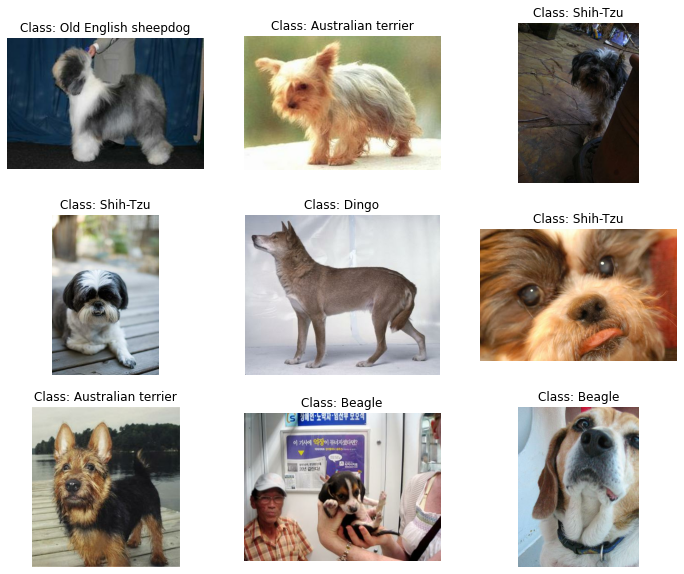

In [0]:
# Anzeigen von 9 Bildern aus dem Trainigsdatensatz
helpers.plot_images(train_data.take(9), classes)

## Preprocessing der Daten

#### Um mit den Bilddaten arbeiten zu können, müssen diese eine einheitliche Größe haben. Dafür stellen wir euch die Funktion `preprocess` bereit, die alle Bilder in die vorgegebene Größe umwandelt


In [0]:
def preprocess(image, label):
    resized_image = tf.image.resize(image/255, [300, 300])
    return resized_image, label

### Laden des Datensatzes


In [0]:
train_data = tfds.load(
    'imagenette/320px',
    split=tfds.Split.TRAIN,
    as_supervised=True
)
test_data = tfds.load(
    'imagenette/320px',
    split=tfds.Split.VALIDATION,
    as_supervised=True
)

# Natürlich lassen sich auf die Trainings und Validation Daten auch über die Variable `data` laden
# Dies kann über data['validation'] und data['train'] passieren.
# Um den Code unabhängig von oben nutzen zu können wurde dies hier noch einmal aufgeführt.

## Vorbereitung der Daten zur schnelleren Verarbeitung
Anwendung der `preprocess` Funktion auf alle Daten

`.batch` bereitet den nächsten Batch mit festeglegter Größe vor

`.prefetch` lädt den nächsten Batch schon in den Speicher


In [0]:
# Festlegung der Batch Größe für die Datenvorbereitung
batch_size = 32 

# Durchmischen der Trainingsdaten, dass nicht mit sortierten Bildern trainiert wird 

train_data = train_data.shuffle(1000) 

print('shape des Trainigsdatensatzes vor dem preprocessing: ', train_data)

train_data = train_data.map(preprocess) \
  .batch(batch_size).prefetch(1)          
test_data = test_data.map(preprocess) \
  .batch(batch_size).prefetch(1)

print('shape des Traingingsdatensatzes nach dem preprocessing: ', train_data)

shape des Trainigsdatensatzes vor dem preprocessing:  <DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
shape des Traingingsdatensatzes nach dem preprocessing:  <DatasetV1Adapter shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)>


#  Aufbau des Netzes



In [0]:
# model
learning_rate=0.001
momentum=0.9
dense_neurons=1000
n_filters=512
n_classes = 10
first_kernel_size=(7,7)
activation='elu'

# Inputgröße muss 300x300 Pixel mit 3 RGB Farben betragen
input_layer = Input(shape=(300, 300, 3))

# Convolutional Neural Network
# 6 Convolutional Layers mit jeweils einer Max Pooling Layer
model = Conv2D(
    filters=32,
    kernel_size=(7,7),
    activation=activation
)(input_layer)

model = Conv2D(
    filters=32,
    kernel_size=(3,3),
    activation=activation
)(model)

model = Conv2D(
    filters = 256, 
#    filters = 64,
    kernel_size=(3,3), 
    activation=activation
)(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
    filters = n_filters, 
#    filters = 128,
    kernel_size=(3,3), 
    activation=activation
)(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
    filters = n_filters, 
#    filters = 256,
    kernel_size=(3,3), 
    activation=activation
)(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
    filters = n_filters, 
    kernel_size=(3,3), 
    activation=activation
)(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
  filters = n_filters, 
  kernel_size=(3,3), 
  activation=activation, 
  padding='same'
)(model)
model = MaxPooling2D((2,2))(model)

# Fully-Connected-Classifier
model = Flatten()(model)
model = Dense(
    dense_neurons,
    activation=activation
)(model)
model = Dropout(0.0)(model)


model = Dense(
    dense_neurons / 2,
    activation='tanh'
)(model)
model = Dropout(0.0)(model)


# Output Layer
output = Dense(n_classes, activation="softmax")(model)
CNN_model = Model(input_layer, output)

# Kompilieren des Modells
# optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum)
#optimizer = keras.optimizers.RMSprop(lr=learning_rate, momentum=momentum)
optimizer = keras.optimizers.SGD(lr=learning_rate)
CNN_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)
CNN_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 294, 294, 32)      4736      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 292, 292, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 290, 290, 256)     73984     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 145, 145, 256)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 143, 143, 512)     1180160   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 71, 71, 512)       0     

In [0]:
# Training des Modells mit 6 Epochen
history2 = CNN_model.fit(
    train_data,
    epochs=12,
    validation_data=test_data
)

Epoch 1/12
403/403 [==============================] - 321s 796ms/step - loss: 2.1727 - accuracy: 0.2394 - val_loss: 1.9227 - val_accuracy: 0.3920
Epoch 2/12
403/403 [==============================] - 316s 783ms/step - loss: 1.8934 - accuracy: 0.3604 - val_loss: 1.6863 - val_accuracy: 0.4140
Epoch 3/12
403/403 [==============================] - 316s 783ms/step - loss: 1.7365 - accuracy: 0.4206 - val_loss: 1.5753 - val_accuracy: 0.4580
Epoch 4/12
403/403 [==============================] - 316s 783ms/step - loss: 1.6159 - accuracy: 0.4656 - val_loss: 1.4969 - val_accuracy: 0.4820
Epoch 5/12
403/403 [==============================] - 315s 782ms/step - loss: 1.5061 - accuracy: 0.5032 - val_loss: 1.3773 - val_accuracy: 0.5540
Epoch 6/12
403/403 [==============================] - 315s 782ms/step - loss: 1.4084 - accuracy: 0.5365 - val_loss: 1.3059 - val_accuracy: 0.5640
Epoch 7/12
403/403 [==============================] - 315s 782ms/step - loss: 1.3226 - accuracy: 0.5675 - val_loss: 1.2341 -

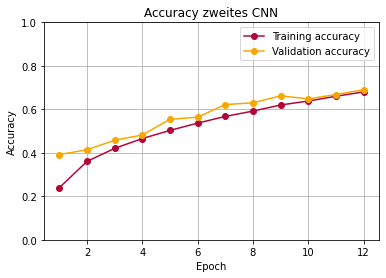

In [0]:
helpers.plot_history('Accuracy zweites CNN', history2, 0)



## Tiefe des Netzes


# Durch praktisches Ausprobieren lernt ihr am besten

Probiert am besten selbst ein wenig herum, mit welchen Konfigurationen des Netzes ihr welche Ergebnisse erzielen könnt.

Diskutiert im Forum, wie ihr das vorgestellte Netz verbessern könnt oder welche Genauigkeiten auf anderen Datensätzen erreicht werden.